##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a stateful RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

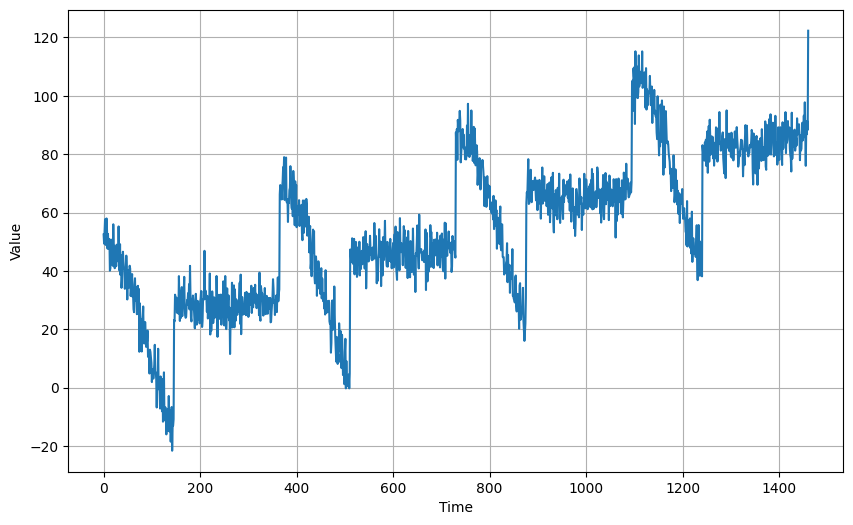

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [5]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 13ms/step - loss: 296.6172 - mae: 297.1172 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 262.3012 - mae: 262.8012 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 223.4797 - mae: 223.9797 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 181.8496 - mae: 182.3496 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 136.5371 - mae: 137.0371 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 86.2916 - mae: 86.7916 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 30.3083 - mae: 30.8059 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 13.9285 - mae: 14.4205 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 1s 20ms/step - loss: 12.6

(1e-08, 0.0001, 0.0, 30.0)

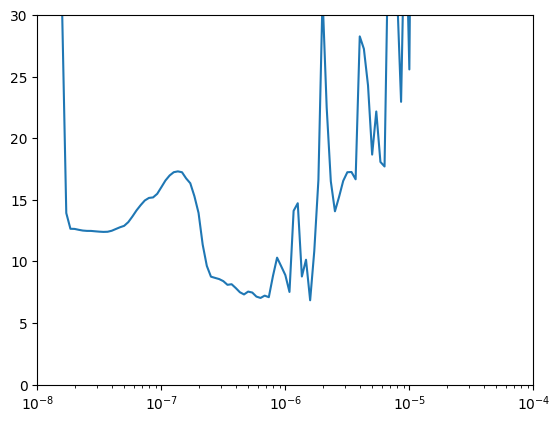

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 3s 30ms/step - loss: 24217.4219 - mae: 24217.9219 - val_loss: 80080.6641 - val_mae: 80081.1641


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 83383.0469 - mae: 83383.5703 - val_loss: 13896.4893 - val_mae: 13896.9893
Epoch 3/500
33/33 [==============================] - 0s 14ms/step - loss: 38440.1250 - mae: 38440.6250 - val_loss: 40950.2305 - val_mae: 40950.7344
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 58034.0820 - mae: 58034.5859 - val_loss: 21677.5195 - val_mae: 21678.0195
Epoch 5/500
33/33 [==============================] - 0s 15ms/step - loss: 36050.8555 - mae: 36051.3594 - val_loss: 4540.7739 - val_mae: 4541.2739
Epoch 6/500
33/33 [==============================] - 0s 14ms/step - loss: 22523.9180 - mae: 22524.4180 - val_loss: 106608.0000 - val_mae: 106608.5078
Epoch 7/500
33/33 [==============================] - 1s 24ms/step - loss: 41429.7852 - mae: 41430.2891 - val_loss: 1459.2444 - val_mae: 1459.7446
Epoch 8/500
33/33 [==============================] - 1s 24ms/step - loss: 42874.4375 - mae: 42874.9336 - val_loss:

In [10]:
model = keras.models.load_model("my_checkpoint.h5")

In [11]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 886ms/step


In [12]:
rnn_forecast.shape

(461,)

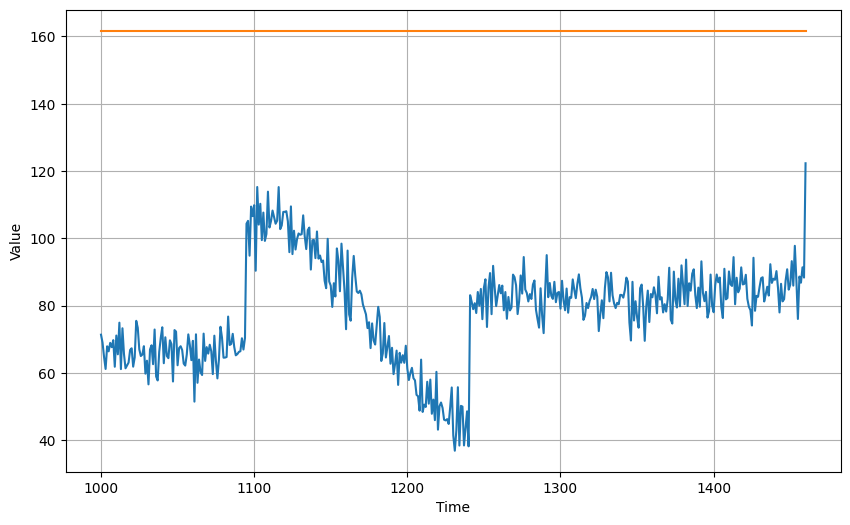

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

83.29393